In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from scipy import stats
import warnings
from TESStools import *
from tqdm.notebook import tqdm

In [7]:
fyps = pd.read_csv('fyps.csv')
this_star = fyps[fyps['CommonName'] == 'HD 269110']
this_star

,CommonName,ContRatio,Dec,Dec_y,MKType,MatchID,RA,RA_y,SimbadOType,SimbadSpT,...,w3mag,w4mag,alpha,e_alpha,tau,e_tau,gamma,e_gamma,alpha_w,e_alpha_w
1,HD 269110,NaN,-69.60339,NaN,K0,40404470,77.294202,NaN,Star,G0I:,...,8.569,8.241,0.00761,0.000319,0.319037,0.01628,1.945853,0.057135,0.001563,6.222184e-07


In [8]:
#prewhitening
tic = this_star['TIC ID'].iloc[0]
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
good_fs, good_amps, good_phases, good_snrs, good_peaks = prewhiten(time, flux, err)
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
freq, power = LombScargle(time, flux, dy=err).autopower(normalization='psd')
power /= len(time)
popt, pcov, resid = fit_red_noise(freq, power)

Found 8 frequencies
8 unique frequencies


In [9]:
for f,s in zip(good_fs,good_snrs):
    print(f[0],s)

0.5528473552386175 19.2634873424709
1.7636676637326696 28.032301933208213
3.5267452996653 18.3354199196981
5.290809185163019 18.89092235705925
0.5418807634618519 14.748738460639627
1.105310075496905 18.32669851890602
0.5637925913128349 7.618927966585378
2.897923125758109 19.27840681340565


In [10]:
ls_dict = {0:'--',1:'-.',2:':'}

[1.76366766] [5.29080919] [3.]


/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/carina/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


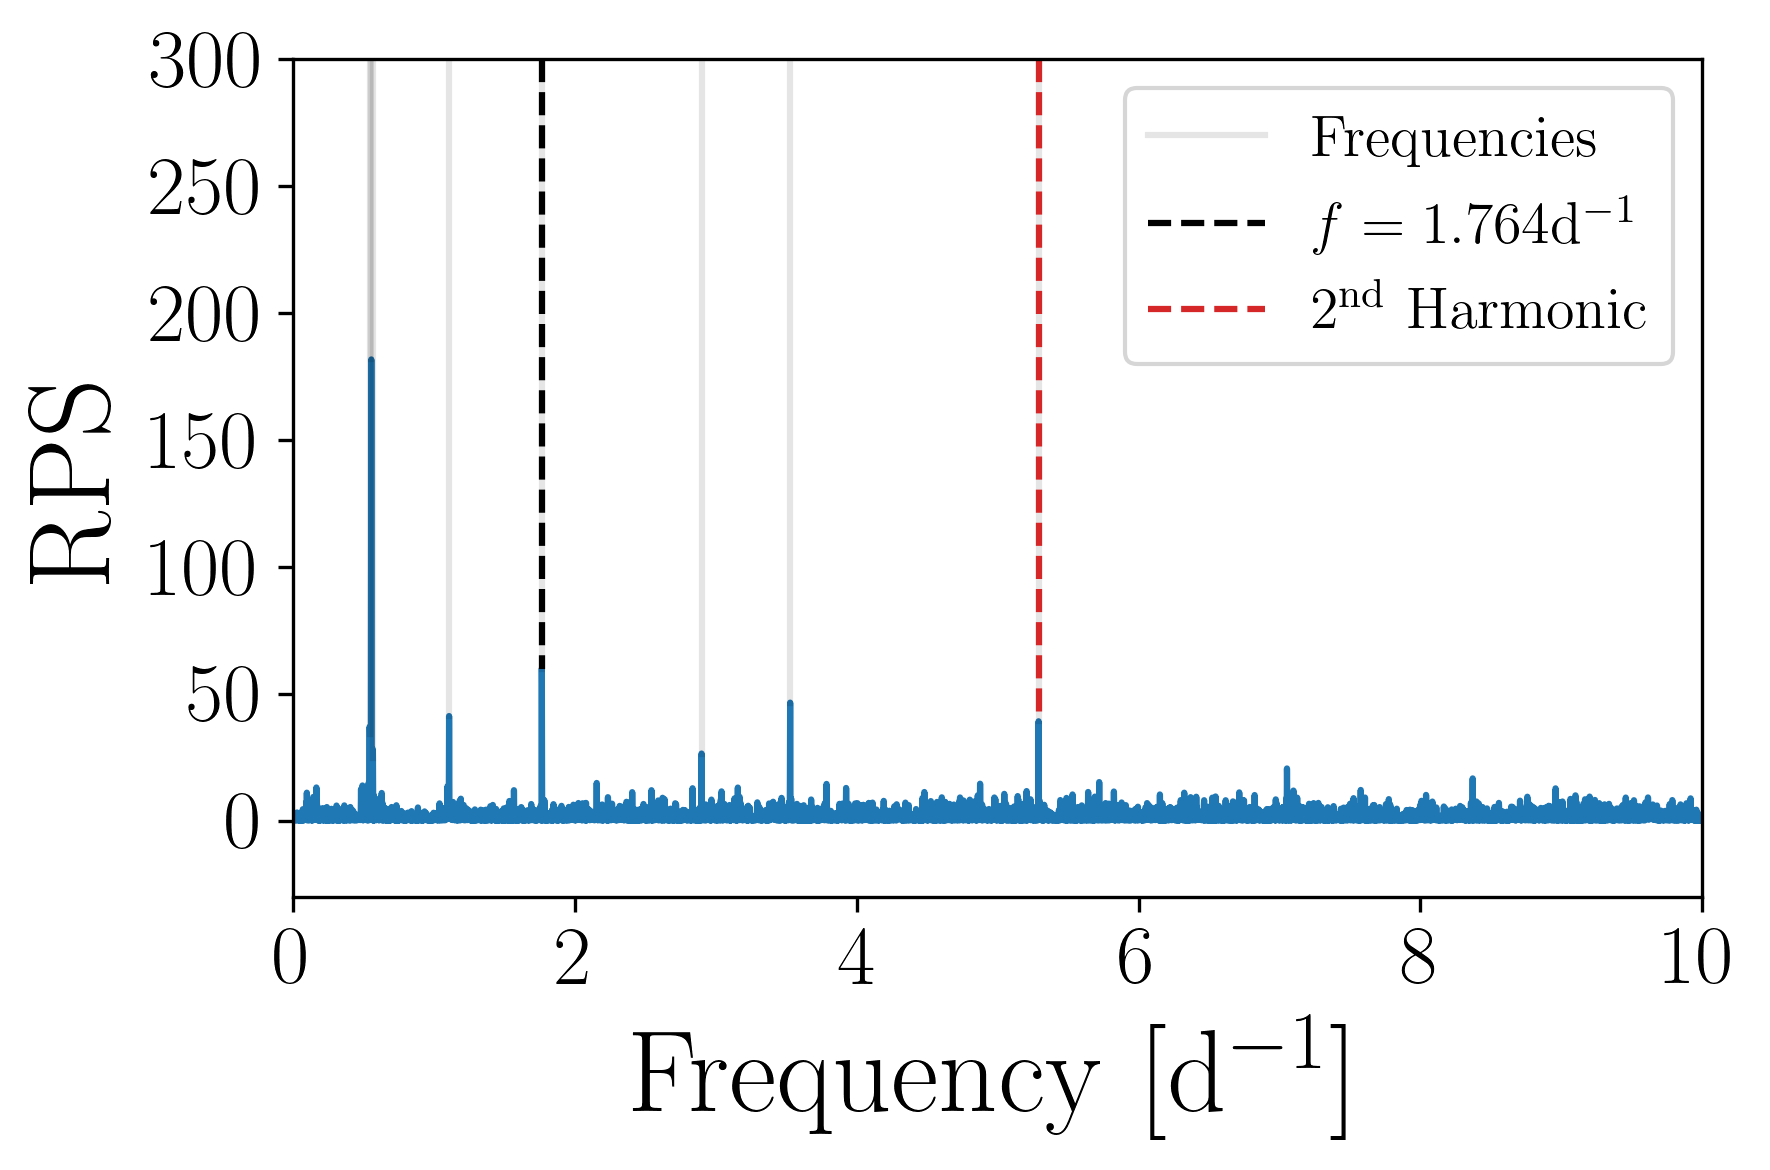

In [53]:
fig = plt.figure(dpi=300)
plt.plot(freq, resid)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='RPS', xlim=(0,10),ylim=(-30,300))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],resid[np.argmin(np.abs(freq-good_fs[0,0]))]],alpha=0.1,c='k',label='Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],resid[np.argmin(np.abs(freq-f))]],c='k',alpha=0.1)

funds, overs, degs = harmonic_search(good_fs)
print(funds,overs,degs)
for num,f in enumerate(np.unique(funds)):
    ls = ls_dict[num]
    plt.plot([f,f],[ylim[1],resid[np.argmin(np.abs(freq-f))]],c='k',ls=ls,label=f'$f={f:.3f}$'+'d$^{-1}$')
    this_over = overs[funds == f]
    this_deg = degs[funds == f]
    for ov, de in zip(this_over, this_deg):
        if de-1 == 1:
            th = 'st'
        elif de-1 == 2:
            th = 'nd'
        elif de-1 == 3:
            th = 'rd'
        else:
            th='th'
        plt.plot([ov,ov],[ylim[1],resid[np.argmin(np.abs(freq-ov))]],c=f'C{int(de)}',ls=ls,label = f'{int(de-1)}'+r'$^{\rm '+ th+'}$ Harmonic')
        
ax.set_ylim(ylim)
leg = ax.legend(fontsize=14)
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.tight_layout()
plt.savefig('../plots/hd269110_frequencies.pdf')

(0, 39.60753957403273)

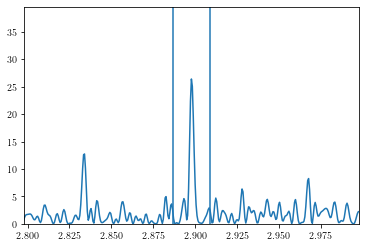

In [51]:
this_f = good_fs[7,0]
plt.plot(freq,resid)
plt.axvline(x=this_f+0.0109)
plt.axvline(x=this_f-0.0109)
plt.xlim(this_f - 0.1,this_f+0.1)
plt.ylim(0,1.5*resid[np.argmin(np.abs(freq-this_f))])

In [20]:
print(good_fs,good_fs[0,0] - good_fs[4,0], good_fs[6,0] - good_fs[0,0],1.0/(good_fs[0,0] - good_fs[4,0]),1.0/(good_fs[6,0] - good_fs[0,0]))

[[5.52847355e-01 3.48551753e-05]
 [1.76366766e+00 1.35930010e-04]
 [3.52674530e+00 2.00086761e-04]
 [5.29080919e+00 2.19290048e-04]
 [5.41880763e-01 7.49472096e-05]
 [1.10531008e+00 1.30502550e-04]
 [5.63792591e-01 9.10676820e-05]
 [2.89792313e+00 2.46906189e-04]] 0.010966591776765622 0.01094523607421738 91.18603303157967 91.36394986998974


In [13]:
#WWZ wavelet fun
#Let's put our functions in a list that we can loop over
func_list = [phi_1,phi_2,phi_3]
f1 = phi_1 #we're also going to need this one explicitly later
#and finally a decay constant for the Gaussian envelope
c = 0.0125
y = flux.values
t = time.values
omega_start = -1 #log2(1/32)
omega_end = 5.5 #log2(16) 
omegas = np.logspace(omega_start,omega_end,1000,base=2)
taus = np.linspace(np.min(t),np.max(t),500)
wwz,wwa = MP_WWZ(func_list,f1,y,t,omegas,taus,c=c)

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


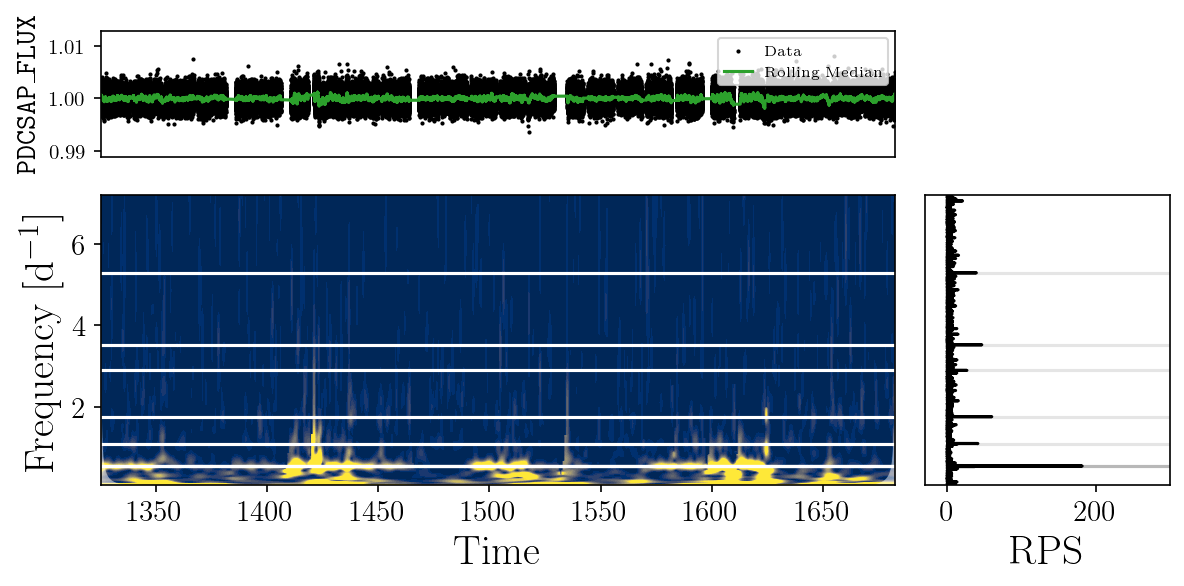

In [54]:
fig = plt.figure(constrained_layout=True,figsize=(8,4),dpi=150)

gs = GridSpec(3, 4, figure=fig)
lcax = fig.add_subplot(gs[0, :3])
wwzax = fig.add_subplot(gs[1:,:3])
zsumax = fig.add_subplot(gs[1:,3])

lcax.scatter(time,flux,s=1,c='k',label=r'Data',rasterized=True)
lcax.plot(lc_smooth['Time'],lc_smooth['Flux'],c='C2',label=r'Rolling Median',rasterized=True)
lcax.set(ylabel=r'$\mathrm{\tt PDCSAP\\\_FLUX}$',xlim=(np.min(time),np.max(time)),xticks=[])
h, l = lcax.get_legend_handles_labels()
lcax.legend(h[::-1],l[::-1],loc='upper right',fontsize='x-small')

wwzax.contourf(taus,omegas/2.0/np.pi,wwz,levels=100,cmap='cividis',vmax=50)
wwzax.fill_between(2*np.pi/omegas+np.min(t),0,omegas/2/np.pi,alpha=0.5,facecolor='white')
wwzax.fill_between(np.max(t)-2*np.pi/omegas,0,omegas/2/np.pi,alpha=0.5,facecolor='white')
wwzax.set(ylabel=r'Frequency [d$^{-1}$]',xlabel='Time',
          ylim=(np.min(omegas)/2/np.pi,np.max(omegas/2/np.pi)))



zsumax.plot(resid,freq,c='k',rasterized=True)
zsumax.set(yticks=[],xlabel=r'RPS',
           ylim=(np.min(omegas)/2/np.pi,np.max(omegas/2/np.pi)),
           xlim=(-30,300))
zs_lim = zsumax.get_xlim()
for f in good_fs[:,0]:
    wwzax.axhline(y=f,c='white')
    zsumax.plot([zs_lim[1],resid[np.argmin(np.abs(freq-f))]],[f,f],c='k',alpha=0.1)
for ax in [lcax,wwzax,zsumax]:
    if ax == lcax:
        ax.xaxis.label.set_size(14)
        ax.yaxis.label.set_size(14)
    else:
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(14)
    plt.tight_layout()
plt.savefig('../plots/hd269110_wwz.pdf')

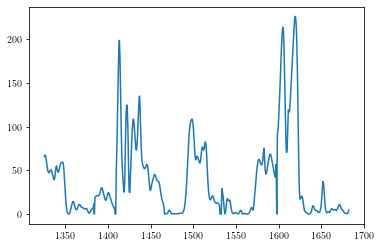

In [31]:
ridge = wwz[np.argmin(np.abs(omegas/2/np.pi - good_fs[0,0])),:]
plt.plot(taus,ridge)
plt.savefig('WOW_time')

0.010362376990261707


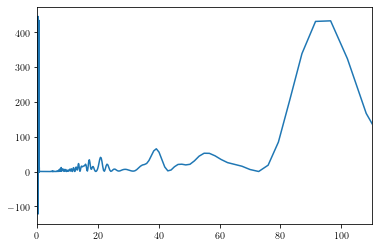

In [39]:
ls_ridge = LombScargle(taus, ridge)
f_ridge, pow_ridge = ls_ridge.autopower(normalization='psd')
pow_ridge /= len(taus)
window = (1.0/f_ridge <= 110) & (1.0/f_ridge >= 40)
plt.plot(1/f_ridge,pow_ridge)
plt.xlim(0,110)
print(f_ridge[window][np.argmax(pow_ridge[window])])
plt.savefig('WOW_power')

In [55]:
def dft_phase(t, y, freq, verbose=False):
    """A discrete fourier transform (DFT) calculates the amplitude and phase of a frequency.
    Normally we discard the phase component. Here, we only want the phase, and the DFT provides it.
    Takes times (t) and brightness variations (y) as well as the frequencies (freq) we are interested in.
    We don't even calculate the full DFT. We only calculate the sines and cosines of exact freqs of interest."""

    freq = np.asarray(freq)
    
    # Not really necessary, but just in case an empty freq array is sent...
    if freq.ndim == 0:
        freq = freq[None]

    # use np arrays because it's computationally quicker.
    t = np.array(t)
    y = np.array(y)
    phase = []
    for f in freq:
        arg = 2.0 * np.pi * f * t
        ft_real = np.sum(y * np.cos(arg))
        ft_imag = np.sum(y * np.sin(arg))

        # use an arctan function to get the phase
        phase.append(np.arctan2(ft_imag,ft_real))
    return phase

In [56]:
def lc_slicer(t, y, dt=10.0):
    """
    Slices the lightcurve into equal slices of width dt
    
    Parameters
    ----------
    t : array-like
        times
    y : array-like
        flux or magnitude measurements
    dt : float
        Size of lightcurve slices in same units as `t`
        
    Returns
    -------
    ts : array-like
        The nth entry of ts will be a time array for the nth lightcurve slice
    ys : array-like
        The nth entry of ys will be a flux/magnitude array for the nth lightcurve slice
    """
    tsort = np.argsort(t)
    
    t = t[tsort]
    y = y[tsort]
    
    if t[0] != 0:
        t -= t[0]
        
    midtime = 0.5*dt
    ts = []
    ys = []
    while midtime <= t[-1]:
        t_chunk = t[np.abs(t - midtime)<0.5*dt]
        y_chunk = y[np.abs(t - midtime)<0.5*dt]
        ts.append(t_chunk)
        ys.append(y_chunk)
        midtime += dt
    return ts, ys

In [57]:
def measure_phase_in_chunk(ts,ys,f):
    """
    Calculates the best-fit phase from the DFT in a light curve, chunked up into bins
    
    Parameters
    ----------
    ts : array-like
        The nth entry of ts will be a time array for the nth lightcurve slice
    ys : array-like
        The nth entry of ys will be a flux/magnitude array for the nth lightcurve slice
    f : float or array-like
        Frequency or frequencies to calculate
        
    Returns
    -------
    midtimes : array-like
        times at the centers of our lightcurve chunks
    phases : array-like
        (len(ts),) or (len(ts),len(fs)) array containing best fit phases
        
    """
    
    midtimes = []
    phases = []
    
    for t,y in zip(ts,ys):
        if len(t) != 0:
            midtimes.append(0.5*(np.max(t)+np.min(t)))
            phases.append(dft_phase(t, y, f, verbose=False))
    return np.array(midtimes),np.array(phases)

In [60]:
ts,ys = lc_slicer(time.values,flux.values)
midtimes,phases = measure_phase_in_chunk(ts,ys,good_fs[:,0])
phases = np.unwrap(phases)
phases -= np.mean(phases,axis=0)

In [61]:
phases.shape

(36, 8)

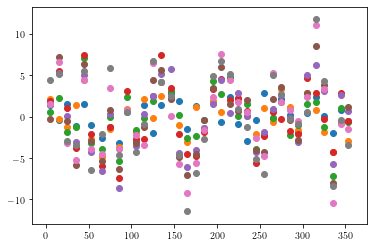

In [62]:
for i in range(8):
    plt.scatter(midtimes,phases[:,i])

(0, 355.5310596282575)

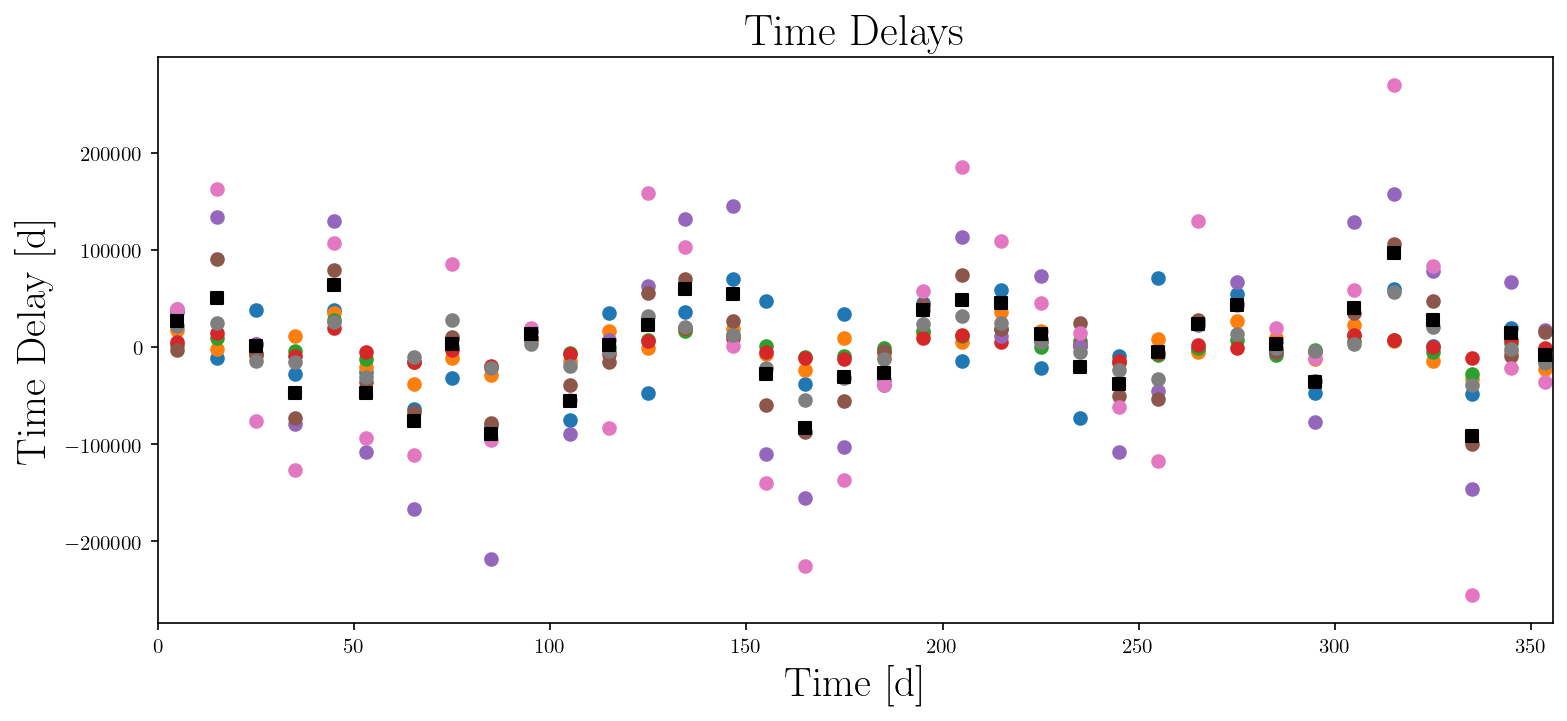

In [70]:
taus = 86400 * phases / (2*np.pi*np.array(good_fs[:,0]))
avgs = np.average(taus, axis=1, weights=good_amps[:,0])
fig = plt.figure(figsize=(12,5),dpi=150)
plt.title('Time Delays',fontsize=21)
for i in range(8):
    plt.scatter(midtimes,taus[:,i],label=f'$f_{i}$')
plt.scatter(midtimes,avgs,c='k',marker='s',label='Weighted Avg.')
plt.xlabel('Time [d]',fontsize=20)
plt.ylabel('Time Delay [d]',fontsize=20)
plt.xlim(0,max(midtimes)+2)
#plt.legend()

11.206786006678255


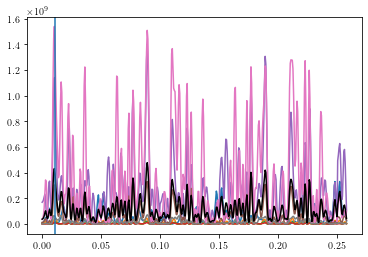

In [79]:
powers = []
for i in range(8):
    ls = LombScargle(midtimes,taus[:,i])
    if i == 0:
        freq, power = ls.autopower(normalization='psd')
    else:
        power = ls.power(freq,normalization='psd')
    power /= len(midtimes)
    plt.plot(freq,power)
    powers.append(power)
avg_power = np.average(np.array(powers), axis=0, weights=good_amps[:,0])
plt.plot(freq,avg_power,c='k')
plt.axvline(x=1/91)
print(1/freq[np.argmax(avg_power)])